In [1]:
import sys
sys.path.append('../')
import atlas

import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Restart models

At the basic level, calculating a model atmosphere comes down to finding a temperature profile (i.e. run of temperature throughout the atmosphere as a function of optical depth) that satisfies *energy equilibrium*, *hydrostatic equilibrium* and the *equation of state*. Seeking the profile that simultaneously meets all three conditions directly is computationally prohibitive in nearly all cases due to the non-linearity of the system and computational cost associated with opacity calculations.

Instead, a trial temperature profile is guessed to start the calculation. At first, the condition of energy equilibrium is entirely disregarded while the other two conditions are solved simultaneously for other parameters of the atmosphere such as opacity, pressure, density and the radiation field. Once the entire atmosphere is solved, energy equilibrium is reconsidered to check which parts of the trial temperature profile are wrong and by how much. Those flux errors are then fed into a *temperature correction scheme* that suggests how the temperature profile may be adjusted in order to suppress departures from the energy equilibrium. Of course, this adjustment will likely break the other two conditions requiring the entire calculation to be repeated but with the corrected temperature profile.

It is then hoped that on every subsequent iteration the refined temperature profile is more accurate than before. Iterations are continued either until all three conditions are upheld within satisfying precision or until no meaningful progress can be made. The latter may be due to one or more of the following reasons:

* A star with desired parameters is physically impossible in which case no temperature profile that satisfies all three conditions will exist.
* One or more of the conditions are genuinely violated in the atmosphere of the star (e.g. the atmosphere may be expanding due to exceeding the Eddington limit, in which case the condition of hydrostatic equilibrium will not hold).
* A star with desired parameters relies on physics that is not included in the model in which case, again, no temperature profile will work. This could, for example, be due to incomplete opacity treatment, significant NLTE (non-local thermodynamic equilibrium) effects, condensation of dust and clouds at low temperatures etc.
* A better temperature profile does exist but the adopted temperature correction scheme is unable to find it.

This notebook explores the last of those four potential problems. Due to the non-linear nature of structure equations, most temperature correction schemes perform better when the necessary changes in the temperature profile are small, allowing them to be approximated as nearly linear. As such, the initial trial temperature profile must be chosen as close to the expected final profile as possible. Failure to do so may increase the number of required iterations (since temperature corrections are applied in small steps) or render the temperature correction routine unable to operate entirely.

Below we review a few choices of the trial temperature profile available to the user and demonstrate their effect on the final result.

### Grey atmosphere

A grey atmosphere is a highly unrealistic model that assumes equal opacity at all wavelengths (except for maybe extremely hot fully ionized atmospheres dominated by Thomson scattering which is genuinely grey). In this simplified scenario, the exact temperature profile may be calculated analytically without resorting to iterative routines. In fact, it is given by the following expression:

$$T=T_\mathrm{eff}\left(\frac{3}{4}\left[\tau + \frac{2}{3} \right] \right)^{1/4}$$

where $\tau$ is the (wavelength-independent) optical depth and $T_\mathrm{eff}$ is the effective temperature. In the absence of other information, one may attempt to use the grey profile corresponding to the desired effective temperature as the trial temperature structure.

We will now calculate a solar atmosphere model in `~/ATLAS_solar_grey`. Make sure the directory does not already exist:

In [2]:
rm -rf ~/ATLAS_solar_grey

To use grey atmosphere as the initial temperature guess, pass an optional argument to `atlas.atlas()` with `restart='grey'`:

In [3]:
run_dir = os.path.expanduser('~/ATLAS_solar_grey')

# Solar parameters are used in the absence of other arguments
atlas.atlas(run_dir, restart = 'grey')

Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 31.732 | max[abs(de)] = 3916.526
30 iterations completed: max[abs(err)] = 2.168 | max[abs(de)] = 163.902
45 iterations completed: max[abs(err)] = 0.634 | max[abs(de)] = 5.315
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_solar_grey successful

Final convergence: max[abs(err)] = 0.634 | max[abs(de)] = 5.315
Saved the model in model.dat
Finished running ATLAS-9 in 0:01:42.884285 s


On my setup, the atmosphere successfully converges taking $45$ iterations, which is an unusually large number for a relatively basic model. Note that in `BasicATLAS`, the adopted condition for convergence is maximum flux error under $1\%$ and maximum flux derivative error under $10\%$. We will now attempt to accelerate the process by choosing a better initial temperature profile than the grey structure used above.

## Restarts

It is typically more efficient to extract the initial temperature guess from a previously calculated atmosphere with parameters similar to those of the target atmosphere. The model atmosphere providing the trial temperature profile is sometimes referred to as the **restart** model. `BasicATLAS` comes with a few restarts available in the `restarts/` directory.

In particular, the restart model `restarts/m0t6000g4.0.dat` was calculated for solar metallicity, $\log(g)=4.0$ and $T_\mathrm{eff}=6000\ \mathrm{K}$ which is sufficiently close to solar parameters for our purposes. We shall use it for our next calculation in a separate directory:

In [4]:
rm -rf ~/ATLAS_solar_restart

In [5]:
run_dir = os.path.expanduser('~/ATLAS_solar_restart')

# python_path is the home directory of BasicATLAS
atlas.atlas(run_dir, restart = atlas.python_path + '/restarts/m0t6000g4.0.dat')

Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 0.427 | max[abs(de)] = 21.022
30 iterations completed: max[abs(err)] = 0.286 | max[abs(de)] = 3.545
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_solar_restart successful

Final convergence: max[abs(err)] = 0.286 | max[abs(de)] = 3.545
Saved the model in model.dat
Finished running ATLAS-9 in 0:01:07.296639 s


On my setup, the atmosphere converged much faster than before and at far lower flux errors. We can double check that both approaches converge on the same final temperature profile by plotting both on the same set of axes:

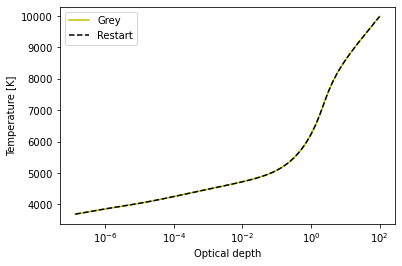

In [7]:
# Load both structures
structure_grey, units_grey       = atlas.read_structure(os.path.expanduser('~/ATLAS_solar_grey'))
structure_restart, units_restart = atlas.read_structure(os.path.expanduser('~/ATLAS_solar_restart'))

# Plot both profiles (temperature vs optical depth)
plt.plot(structure_grey['rosseland_optical_depth'], structure_grey['temperature'], 'y-', label = 'Grey')
plt.plot(structure_restart['rosseland_optical_depth'], structure_restart['temperature'], 'k--', label = 'Restart')

# Legend and labels
plt.xlabel('Optical depth')
plt.ylabel('Temperature [{}]'.format(units_grey['temperature']))
plt.legend()
plt.xscale('log')

For any other model, one must choose a restart model that has properties as close as possible to the target.

All restarts available in `BasicATLAS` can be viewed with `atlas.load_restarts()`. The output of this function is a Python dictionary with keys corresponding to file names, effective temperatures, surface gravities and metallicities of all models in `restarts/`:

Text(0.5, 0, 'Effective temperature [K]')

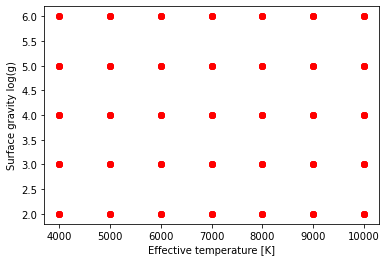

In [8]:
all_restarts = atlas.load_restarts()

# Plot all available effective temperatures and gravities:
plt.plot(all_restarts['teff'], all_restarts['logg'], 'ro')
plt.ylabel('Surface gravity log(g)')
plt.xlabel('Effective temperature [K]')

The grid spans effective temperatures between $4000$ and $10000$ $\mathrm{K}$, surface gravities ($\log(g)$) between $2.0$ and $6.0$ and metallicities $[\mathrm{M}/\mathrm{H}]$ between $-2.0$ and $+1.0$.

In general, it is not necessary to look for the most appropriate restart by hand as `BasicATLAS` can do so automatically. In order to delegate the choice of the restart model to `BasicATLAS`, set the `restart` argument to `auto` (which is also the default value). In the cell below we recalculate the solar model using the `auto` option instead of choosing the restart ourselves.

In [9]:
rm -rf ~/ATLAS_solar_restart

In [10]:
atlas.atlas(run_dir, restart = 'auto')

Automatically chosen restart: /home/roman/CoolStar/BasicATLAS/restarts/m0t6000g4.0.dat
Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 0.427 | max[abs(de)] = 21.022
30 iterations completed: max[abs(err)] = 0.286 | max[abs(de)] = 3.545
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_solar_restart successful

Final convergence: max[abs(err)] = 0.286 | max[abs(de)] = 3.545
Saved the model in model.dat
Finished running ATLAS-9 in 0:01:07.435113 s


As stated in the output, `BasicATLAS` chose the same restart we used in the previous example and, hopefully, arrived at the same flux error and the same final result.

## Custom restarts

The choice of restart models needs not be confined to the library of restarts provided in `BasicATLAS`. Any previously calculated `ATLAS` model can be used as a restart file for another model. To demonstrate this, the cell below calculates another solar model using our previous effort, `~/ATLAS_solar_restart` as the restart file. As one would expect, this ensures nearly instant convergence:

In [11]:
rm -rf ~/ATLAS_solar_restart_2

In [12]:
restart_dir = os.path.expanduser('~/ATLAS_solar_restart')
run_dir = os.path.expanduser('~/ATLAS_solar_restart_2')

atlas.atlas(run_dir, restart = restart_dir)

Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 0.232 | max[abs(de)] = 5.265
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_solar_restart_2 successful

Final convergence: max[abs(err)] = 0.232 | max[abs(de)] = 5.265
Saved the model in model.dat
Finished running ATLAS-9 in 0:00:33.184074 s


The user may also add custom restart models to the `BasicATLAS` library in which case they will be included in the process of automatic selection with `restart=auto`. The list of paths where `BasicATLAS` is looking for suitable restarts is given in `atlas.restart_paths`:

In [13]:
atlas.restart_paths

['/home/roman/CoolStar/BasicATLAS/restarts']

At the moment, the list only includes `restarts/`. By adding the home directory to this list, all previously calculated models will be added to the library as well:

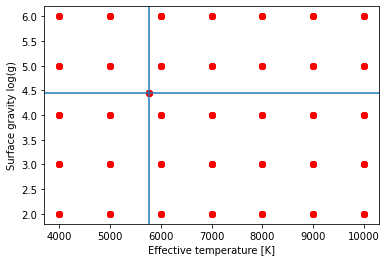

In [15]:
# Add home directory to the restarts library
atlas.restart_paths += [os.path.expanduser('~/')]

# Query all available restarts again
all_restarts = atlas.load_restarts()

# Make the same plot of available restarts: notice the added point at solar parameters
plt.plot(all_restarts['teff'], all_restarts['logg'], 'ro')
plt.ylabel('Surface gravity log(g)')
plt.xlabel('Effective temperature [K]')

# Highlight the solar parameters with horizontal and vertical lines:
plt.axvline(atlas.Settings().teff)
plt.axhline(atlas.Settings().logg)

Now that our solar model is present in the `BasicATLAS` restart library, it is available to be chosen with `restart = 'auto'`. Should we try to calculate a solar model with automatic restart selection once again, `BasicATLAS` will likely choose our solar restart due to it being closest (in fact, identical) to the desired parameters:

In [16]:
rm -rf ~/ATLAS_solar_restart

In [17]:
run_dir = os.path.expanduser('~/ATLAS_solar_restart')
atlas.atlas(run_dir, restart = 'auto')

Automatically chosen restart: /home/roman//ATLAS_solar_grey
Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 0.303 | max[abs(de)] = 6.264
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_solar_restart successful

Final convergence: max[abs(err)] = 0.303 | max[abs(de)] = 6.264
Saved the model in model.dat
Finished running ATLAS-9 in 0:00:32.933687 s


### Uncharted territory

The default set of restarts only covers the most common area of the parameter space. Furthermore, all models in the library are restricted to metallicity-scaled solar abundances. When going beyond the range of available restarts, we may begin struggling to converge due to the nearest available restart being too dissimilar to the model of interest.

This can be clearly illustrated by considering high-gravity models with $T_\mathrm{eff}$ below the `BasicATLAS` restart library limit of $4000\ \mathrm{K}$. Calculations at effective temperatures this low are particularly involved due to molecular effects and, sometimes, even the difference of $200\ \mathrm{K}$ between the target and restart effective temperatures will render the temperature correction scheme of `ATLAS` unable to do its job.

The cells below illustrate this by attempting a calculation at $T_\mathrm{eff}=3800\ \mathrm{K}$ using restart auto selection:

In [18]:
rm -rf ~/ATLAS_cool

In [19]:
run_dir = os.path.expanduser('~/ATLAS_cool')

settings = atlas.Settings()
settings.teff = 3800
settings.logg = 6.0

# "auto" used by default, no need to explicitly specify it as was done in previous cells
atlas.atlas(run_dir, settings = settings)

Automatically chosen restart: /home/roman/CoolStar/BasicATLAS/restarts/m0t4000g6.0.dat
Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 34.213 | max[abs(de)] = 28.838
30 iterations completed: max[abs(err)] = 50.153 | max[abs(de)] = 26.246
45 iterations completed: max[abs(err)] = 49.539 | max[abs(de)] = 21.929
60 iterations completed: max[abs(err)] = 52.491 | max[abs(de)] = 24.84
75 iterations completed: max[abs(err)] = 99.995 | max[abs(de)] = 14.147
90 iterations completed: max[abs(err)] = 85.923 | max[abs(de)] = 11.598
105 iterations completed: max[abs(err)] = 55146.996 | max[abs(de)] = 1156.398
120 iterations completed: max[abs(err)] = 376405.754 | max[abs(de)] = 8073.029
135 iterations completed: max[abs(err)] = 197514.453 | max[abs(de)] = 3947.152
150 iterations completed: max[abs(err)] = 124836.548 | max[abs(de)] = 2241.121
165 iterations completed: max[abs(err)] = 53893.349 | max[abs(de)] = 9763.271
180 iterations completed: max[abs(err)]

On my setup, the model above takes some $15$ minutes before `BasicATLAS` decides that the established convergence criteria are not attainable and gives up. One may also notice that the flux errors appear to increase with iterations which implies that the temperature correction scheme is unable to determine which way the temperature profile needs to be adjusted in order to satisfy energy equilibrium better. This behavior is not at all surprising due to the non-linearities in the structure equations introduced by low-temperature physics that leave the temperature correction routine unable to "see" the parameter space clearly enough. The further away the temperature profile got from the correct solution, the harder it was for `ATLAS` to improve it resulting in making even more of a mess with flux errors reaching hundreds of thousands of percent (!). The final temperature profile found by `ATLAS`, in fact, appears to be worse than the initial guess!

As mentioned in the introduction, we can help `ATLAS` by reducing the gap between the target and restart parameters to suppress non-linear effects. For example, we can try to calculate a slightly warmer model first and then use it as a restart for the desired model.

In [20]:
rm -rf ~/ATLAS_intermediate

In [21]:
run_dir = os.path.expanduser('~/ATLAS_intermediate')

# Attempting to calculate a warmer model at 3900 K - the half-way point between the nearest available
# restart in the library at 4000 K and the desired model at 3800 K
settings = atlas.Settings()
settings.teff = 3900
settings.logg = 6.0

# "auto" used by default
atlas.atlas(run_dir, settings = settings)

Automatically chosen restart: /home/roman/CoolStar/BasicATLAS/restarts/m0t4000g6.0.dat
Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 4.842 | max[abs(de)] = 34.753
30 iterations completed: max[abs(err)] = 2.513 | max[abs(de)] = 2.824
45 iterations completed: max[abs(err)] = 1.909 | max[abs(de)] = 2.718
60 iterations completed: max[abs(err)] = 1.595 | max[abs(de)] = 3.366
75 iterations completed: max[abs(err)] = 1.363 | max[abs(de)] = 4.501
90 iterations completed: max[abs(err)] = 1.275 | max[abs(de)] = 4.526
105 iterations completed: max[abs(err)] = 1.131 | max[abs(de)] = 3.456
120 iterations completed: max[abs(err)] = 1.151 | max[abs(de)] = 3.163
135 iterations completed: max[abs(err)] = 1.186 | max[abs(de)] = 4.617
150 iterations completed: max[abs(err)] = 0.983 | max[abs(de)] = 6.19
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_intermediate successful

Final convergence: max[abs(err)] = 0.983 | max[abs(de)] = 6.1

While still struggling with a noticeably harder computation that the solar model, `ATLAS` eventually finds a convergent solution with satisfactory flux errors. We will now attempt to recalculate the original target model, `~/ATLAS_cool`, using the model above as the restart file instead of allowing `BasicATLAS` to choose one from its library (alternatively, we can also add the intermediate model to the library):

In [22]:
rm -rf ~/ATLAS_cool_from_intermediate

In [23]:
run_dir = os.path.expanduser('~/ATLAS_cool_from_intermediate')
restart_dir = os.path.expanduser('~/ATLAS_intermediate')

settings = atlas.Settings()
settings.teff = 3800
settings.logg = 6.0

# "auto" used by default
atlas.atlas(run_dir, settings = settings, restart = restart_dir)

Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 3.551 | max[abs(de)] = 13.339
30 iterations completed: max[abs(err)] = 2.267 | max[abs(de)] = 6.743
45 iterations completed: max[abs(err)] = 1.924 | max[abs(de)] = 6.571
60 iterations completed: max[abs(err)] = 1.536 | max[abs(de)] = 5.675
75 iterations completed: max[abs(err)] = 1.338 | max[abs(de)] = 4.617
90 iterations completed: max[abs(err)] = 1.137 | max[abs(de)] = 3.84
105 iterations completed: max[abs(err)] = 1.001 | max[abs(de)] = 3.188
120 iterations completed: max[abs(err)] = 1.075 | max[abs(de)] = 3.054
135 iterations completed: max[abs(err)] = 1.115 | max[abs(de)] = 2.948
150 iterations completed: max[abs(err)] = 0.927 | max[abs(de)] = 3.238
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_cool_from_intermediate successful

Final convergence: max[abs(err)] = 0.927 | max[abs(de)] = 3.238
Saved the model in model.dat
Finished running ATLAS-9 in 0:09:21.245772 s


By taking a smaller step in $T_\mathrm{eff}$, the same $3800\ \mathrm{K}$ model was able to converge successfully. To illustrate how incorrect our original take on the $3800\ \mathrm{K}$ model was, both attempts are plotted below on the same set of axes:

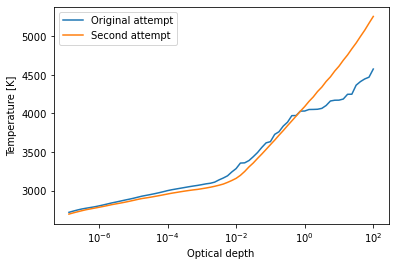

In [24]:
# Load structures from both attempts
structure_1, units_1 = atlas.read_structure(os.path.expanduser('~/ATLAS_cool'))
structure_2, units_2 = atlas.read_structure(os.path.expanduser('~/ATLAS_cool_from_intermediate'))

# Plot both profiles (temperature vs optical depth)
plt.plot(structure_1['rosseland_optical_depth'], structure_1['temperature'], label = 'Original attempt')
plt.plot(structure_2['rosseland_optical_depth'], structure_2['temperature'], label = 'Second attempt')

# Legend and labels
plt.xlabel('Optical depth')
plt.ylabel('Temperature [{}]'.format(units_1['temperature']))
plt.legend()
plt.xscale('log')